## 21点游戏规则

游戏有两方，玩家(player)和庄家(dealer)，玩家和庄家各发两张牌，一张明牌，一张暗地牌。

玩家和庄家需要决定加牌，或者停止加牌，新加的牌均为暗牌，对方看不到，最后需要去比较两个玩家的牌面和，更接近`21`点的玩家获胜， 但是不能超过21点。



- Gym的官方源码地址为: https://github.com/openai/gym/blob/master/gym/envs/toy_text/blackjack.py


1. 花牌(Jack Queen, King)的点数当作为10。
2. `Ace`牌是一个变化因素，既可以作为`11`也可以作为`1`来计算。
3. 数值牌(2-9)的点数就是其本身。

因此，整个牌面被设置为:

```python
# 1 = Ace, 2-10 = Number cards, Jack/Queen/King = 10
deck = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10]
```

- https://blog.csdn.net/qq_36795658/article/details/100533639
- https://www.freesion.com/article/5801254343/

## Off-Policy

在Off-Policy中，一个Policy用于执行动作，另外一个Policy用于估计

## 环境理解

In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
env = gym.make("Blackjack-v0")

### 状态空间

状态空间是一个离散的变量，包含以下三个元素:

1. 玩家当前的点数之和，其值属于$1, \cdots, 31$。
2. 庄家朝上的牌的点数之和，其值属于$1, \cdots, 10$。
3. 玩家是否有能够使用的王牌：(No = 0, Yes = 1)。

其gym中的源码定义如下:

```python
self.observation_space = spaces.Tuple((spaces.Discrete(32), spaces.Discrete(11), spaces.Discrete(2)))
```

In [2]:
env.observation_space

Tuple(Discrete(32), Discrete(11), Discrete(2))

### 动作空间

在这个环境中，有两种action。

1. request additional cards (hit = 1) 1表示要牌。
2. stop (stick = 0), 0表示不要牌。

在这个环境中，reward定义如下:

1. 获得胜利，reward = 1。
2. 平局，reward = 0。
3. 输掉比赛(或是超过21点), reward = -1。

In [3]:
env.action_space

Discrete(2)

### 测试环境

In [4]:
observation = env.reset()
for _ in range(10):
    # env.render()
    action = env.action_space.sample()
    observation, reward, done, info = env.step(action)
    print("observation: ", observation)
    if done:
        observation = env.reset()
env.close()

observation:  (19, 10, False)
observation:  (19, 10, False)
observation:  (27, 2, False)
observation:  (17, 6, False)
observation:  (17, 10, False)
observation:  (15, 4, False)
observation:  (15, 4, False)
observation:  (16, 10, False)
observation:  (16, 10, False)
observation:  (14, 5, False)


## 训练主逻辑

### 定义智能体状态空间

状态是包含玩家的点数和

1. 智能体的牌数总和状态空间agentSumSpace为4-21, 因为A是可以当作1的，所以最小的就是两张2, 并且超过21点的话，游戏就会结束。
2. 一张明牌dealerShowCardSpace的大小为1-10。
3. 智能体的AceSpace空间为两个维度，是否将其作为11。
4. 动作空间actionSpace表示是否要牌。

之后遍历`agentSumSpace`，`dealerShowCardSpace`和`agentAceSpace`，我们就可以获得状态`(total, card, ace)`，对应的`Q`即为`Q[((total, card, ace), action)]`。

In [5]:

agentSumSpace = [i for i in range(4, 22)]
dealerShowCardSpace = [i+1 for i in range(10)]
agentAceSpace = [False, True]
actionSpace = [0, 1]

### 初始化Q和状态空间

初始化Q函数，穷举所有的状态空间，初始化期望，初始化sa的访问次数。

In [6]:
Q = {}  # 初始化Q函数，用于估计某个状态下采取某个动作的未来期望收益。
C = {}  # 权重weight
stateSpace = []
returns = {}
pairsVisited = {}
for total in agentSumSpace:
    for card in dealerShowCardSpace:
        for ace in agentAceSpace:
            for action in actionSpace:
                Q[((total, card, ace), action)] = 0 # 初始化Q值。
                C[((total, card, ace), action)] = 0 # 初始化Q值。
                returns[((total, card, ace), action)] = 0 # 初始化回报奖励。
                pairsVisited[((total, card, ace), action)] = 0 # 初始化访问的s，a次数。
            stateSpace.append((total, card, ace)) # 穷举所有的状态空间

### 初始化策略

初始化一个随机的策略。

In [7]:
policy = {}
for state in stateSpace:
    policy[state] = np.random.choice(actionSpace) # MC策略是对于每个状态随机选择动作。

目标策略计算最优的行为策略:

In [8]:
targetPolicy = {}
for state in stateSpace:
    values = np.array([Q[state, a] for a in actionSpace])
    best = np.random.choice(np.where(values == values.max())[0])
    targetPolicy[state] = actionSpace[best]

starting episode 0
starting episode 100000
starting episode 200000
starting episode 300000
starting episode 400000
starting episode 500000
starting episode 600000
starting episode 700000
starting episode 800000
starting episode 900000
Getting Ready To Test Policy
win rate 0.316 loss rate 0.626 draw rate 0.058


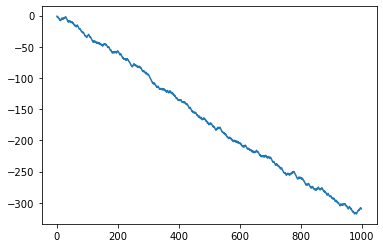

In [9]:
if __name__ == "__main__":
    env = gym.make('Blackjack-v0')
    EPS = 0.05
    GAMMA = 1.0

    numEpisodes = 1000000 # 回合总数
    for i in range(numEpisodes):
        statesActionsReturns = [] # 用于记录每个状态动作对应的回报收益。
        memory = []
        if i % 100000 == 0:
            print("starting episode", i)
        
        behaviorPolicy = {} # 行为策略采用贪婪策略。
        for state in stateSpace:
            rand = np.random.random()
            if rand < 1 - EPS:
                behaviorPolicy[state] = [targetPolicy[state]]
            else:
                behaviorPolicy[state] = actionSpace
        
        observation = env.reset()
        done = False
        while not done:
            action = np.random.choice(behaviorPolicy[observation]) # 基于策略选择动作。
            observation_, reward, done, info = env.step(action)
            memory.append((observation[0], observation[1], observation[2], action, reward))
            observation = observation_
        memory.append((observation[0], observation[1], observation[2], action, reward)) # 添加最后一个状态，之后会丢弃
        
        G = 0 # 计算期望回报
        W = 1
        last = True
        for playerSum, dealerCard, usableAce, action, reward in reversed(memory):
            sa = ((playerSum, dealerCard, usableAce), action)
            if last:
                last = False
            else:
                C[sa] += W
                Q[sa] += (W / C[sa]) * (G - Q[sa])
                values = np.array([Q[state, a] for a in actionSpace])
                best = np.random.choice(np.where(values == values.max())[0])
                targetPolicy[state] = actionSpace[best]
                
                if action != targetPolicy[state]: # 如果不是选择了targetPolicy就退出。
                    break
                
                if len(behaviorPolicy[state]) == 1:
                    prob = 1 - EPS
                else:
                    prob = EPS / len(behaviorPolicy[state])
                
                W *= 1 / prob
                
            G = GAMMA*G + reward
            
        if EPS - 1e-7 > 0: # 贪婪策略的贪婪因子递减。
            EPS -= 1e-7
        else:
            EPS

    # 测试
    numEpisodes = 1000
    rewards = np.zeros(numEpisodes)
    totalReward = 0
    wins = 0
    losses = 0
    draws = 0
    print("Getting Ready To Test Policy")
    for i in range(numEpisodes):
        observation = env.reset()
        done = False
        while not done:
            action = targetPolicy[observation]
            observation_, reward, done, info = env.step(action)
            observation = observation_
        totalReward += reward
        rewards[i] = totalReward

        if reward >= 1:
            wins += 1
        elif reward == 0:
            draws += 1
        elif reward == -1:
            losses += 1

    wins /= numEpisodes
    losses /= numEpisodes
    draws /= numEpisodes
    print('win rate', wins, 'loss rate', losses, 'draw rate', draws)
    plt.plot(rewards)
    plt.show() 